# Longitudinal data analysis for sparse observations

Longitudinal data arises whenever we observe subjects over some period of time. A typical example of such data is a clinical setting where patients come to a clinic mulitple times in their lives and doctors measure certain parameters such as the glucose level, blood pressure, etc. `fcomplete` package allows you to model this kind of data. In this vignette we will present how to use basic methods of the package on an example dataset.

## Bones dataset

A classical 'textbook' example of longitudinal data comes from a study of Bachrach et al. (1999), where they analyze spinal bone minaral density of patients. We load this data from the [*Elements of statistical learning*](https://web.stanford.edu/~hastie/ElemStatLearn/) book and we plot the first 100 observations, treating observations independently.

In [21]:
library("fcomplete")
head(bone)

,idnum,age,gender,spnbmd,pred.fimpute
,<int>,<dbl>,<fct>,<dbl>,<dbl>
1,1,11.70,male,0.018080670,0.05698596
2,1,12.70,male,0.060109290,0.05457628
3,1,13.75,male,0.005857545,0.05165354
4,2,13.25,male,0.010263930,0.05371180
5,2,14.30,male,0.210526300,0.04739565
6,2,15.30,male,0.040843210,0.03903100


In this dataset, `idnum` corresponds to the subject's id, `age` is the age at the time of measurement, `gender` takes two values: `male` and `female` and `spnbmd` is the actual measurement of the spine bone marrow density. Note that `spnbmd` is measured after removing the population mean, so it contains negative values.

First, we plot a subset of this data (100 measurements).

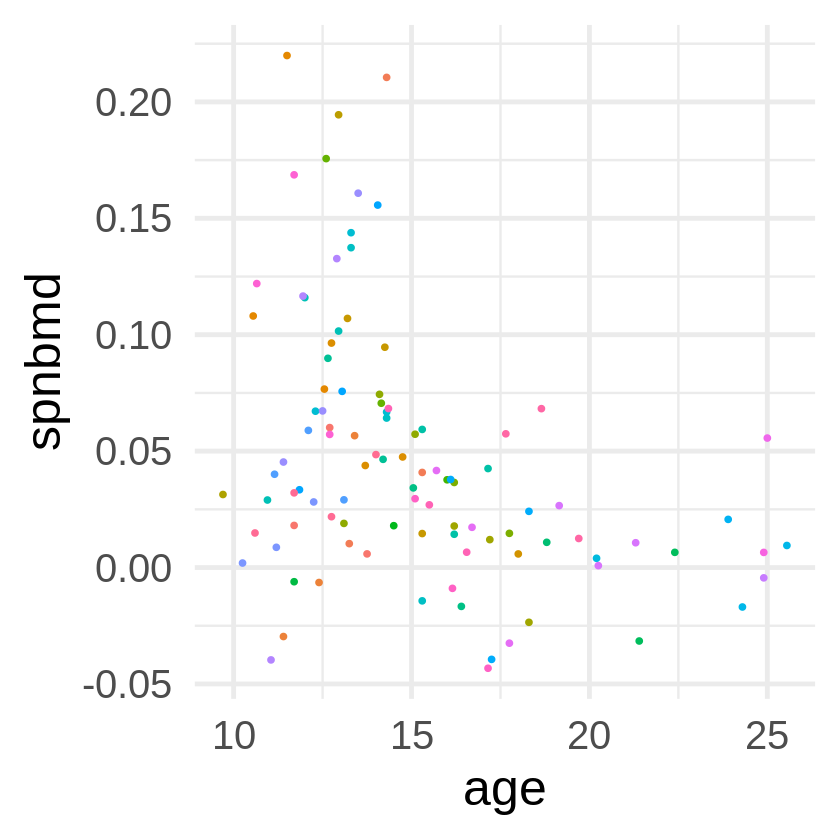

In [2]:
theme_set(theme_minimal(base_size = 30,)) # choose a theme and large font for presentation clarity

ggplot(aes(x = age, y = spnbmd, color = factor(idnum)), data = bone[1:100,]) +
    geom_point() + theme(legend.position="none")

Since data come from multiple observationso of patients, we have additional structure. Below, we connect with lines observations coming from the same subjects.

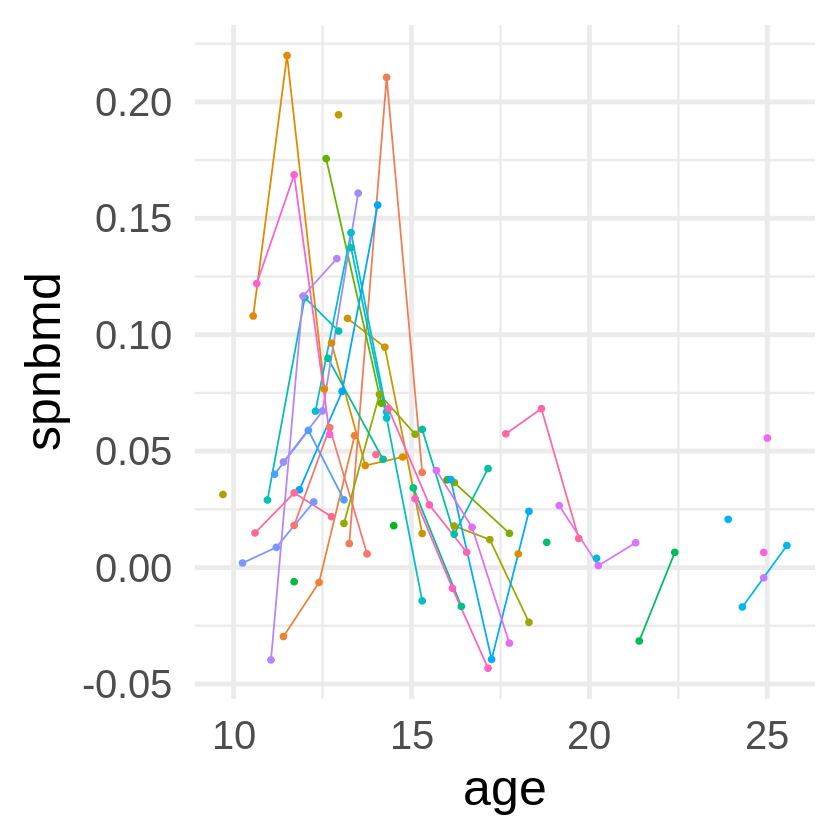

In [3]:
ggplot(aes(x = age, y = spnbmd, color = factor(idnum)), data = bone[1:100,]) +
    geom_line() + geom_point() + theme(legend.position="none")

`fcomplete` package allows us to estimate individual progression trends of patients and, therefore, it allows us to predict the development after the last measurement. Although we have only a few observations per subject, our methods leverage similarities between subjects.

## Basic fit and its properties

There are multiple methods for estimating trajectories. In this package, the default method comes from Kidziński and Hastie (2021). To fit the model you can simply use the `fregression` function from the package

In [4]:
fit.fimpute = fregression(spnbmd ~ age | idnum, data = bone, d = 6, K = 2, lambda=0.2, verbose = 0)
print(fit.fimpute)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


fcomplete fitted using the 'fimpute' method with a formula: ~spnbmdage | idnum
  Number of fitted subjects (N):	 261
  Number of evaluation timpoints:	 51
  Maximum dimension (K):		 2
  Observed to N*K ratio:		 0.9291188
  Estimated r-squared:			 0.5541487

The fitted model follows generic structure of R models and typical methods, such as `predict`, `summary`, `plot`, `fitted`, `residuals`, `coef` are available. Here we show how to use these methods. To make predictions we can either provide timepoints and ids of subjects or a new data frame with the same variable names. 

### Model pedictions

If we only provide `ids` of subjects, we will get entire predicted trajectories

In [5]:
predict(fit.fimpute, ids=c(2,5,10))

,9.4,9.723,10.046,10.369,10.692,11.015,11.338,11.661,11.984,12.307,⋯,22.643,22.966,23.289,23.612,23.935,24.258,24.581,24.904,25.227,25.55
2,0.06055918,0.06024899,0.0598739,0.0594313,0.05891805,0.05833654,0.05769113,0.05698596,0.05622472,0.05541754,⋯,0.002078876,0.001318292,0.0005679652,-0.000170758,-0.0008983435,-0.001611489,-0.00230925,-0.002992251,-0.003658022,-0.004308392
5,0.06055918,0.06024899,0.0598739,0.0594313,0.05891805,0.05833654,0.05769113,0.05698596,0.05622472,0.05541754,⋯,0.002078876,0.001318292,0.0005679652,-0.000170758,-0.0008983435,-0.001611489,-0.00230925,-0.002992251,-0.003658022,-0.004308392
10,0.06055918,0.06024899,0.0598739,0.0594313,0.05891805,0.05833654,0.05769113,0.05698596,0.05622472,0.05541754,⋯,0.002078876,0.001318292,0.0005679652,-0.000170758,-0.0008983435,-0.001611489,-0.00230925,-0.002992251,-0.003658022,-0.004308392


We can specify the exact points at which we want to get predictions with the `time` argument 

In [6]:
predict(fit.fimpute, ids=c(2,5,10), time=c(12,13,20))

,12,13,20
2,0.05622472,0.0537118,0.009312417
5,0.05622472,0.0537118,0.009312417
10,0.05622472,0.0537118,0.009312417


Finally, for compatibility with the *long* data format, we can simply provide a `newdata` dataframe with exact points at which we want to make predictions

In [7]:
newdata = data.frame(idnum=c(2,2,5,10), age=c(10, 12, 11, 20))
predict(fit.fimpute, newdata)

[1] 0.060248985 0.056224723 0.058918053 0.009312417

To get predictions on the training dataset we can simply use the `fitted` function. This allows us, for example, to quickly diagnose the difference between the true and predicted values.

Warning message:
“Use of `bone$spnbmd` is discouraged. Use `spnbmd` instead.”


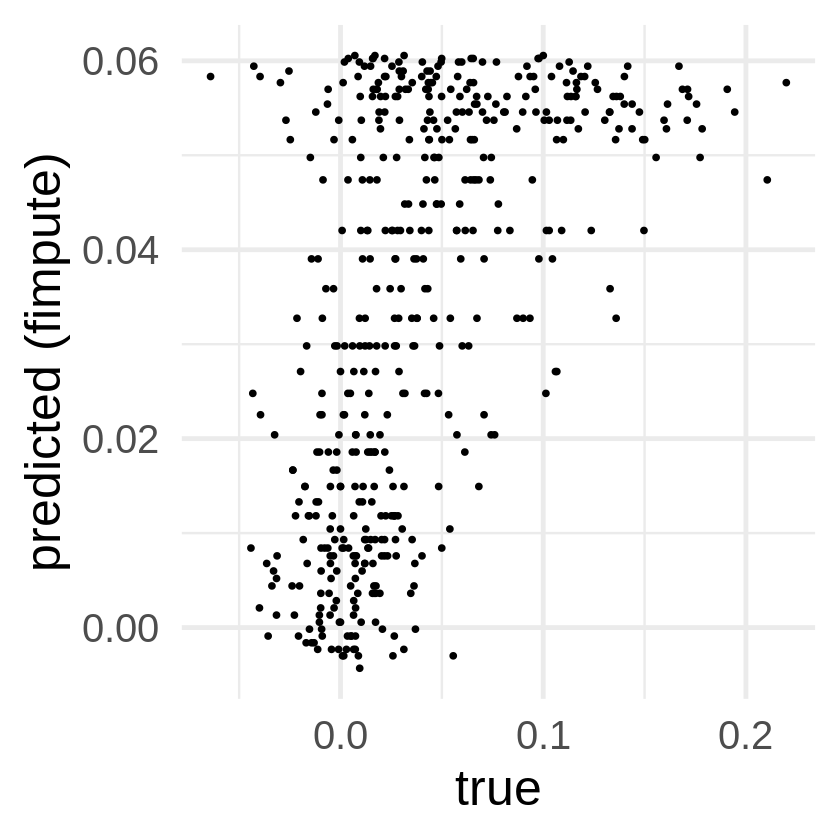

In [8]:
bone$pred.fimpute = fitted(fit.fimpute)
ggplot(bone, aes(x=bone$spnbmd, y=pred.fimpute)) + xlab("true") + ylab("predicted (fimpute)") +  geom_point()

Similarly, we can look on residuals and, for example, compute the error relative to variability in the data (the mean squared error):

In [9]:
sum(residuals(fit.fimpute)**2) / sum(bone$spnbmd**2)

[1] 0.4458513

**Note that these are only *in-sample* predioctions**, i.e. predictions on points that the model has seen during training. It is important to assess the out-sample properties. We investigate this in [a later section](#Quantitative-evaluation-of-models).

### Model coefficients and components

In our method, after fitting the model, each subject is represented by a latent vector $w_i \in \mathbb{R}^K$ which corresponds to coefficients in a fitted basis. The basis is composed of $K$ components $v_j \in \mathbb{R}^T$, for $j \in \{1,2,3,...,K\}$, where $T$ is the size of the evaluation grid. Components are normalized ($\|v_j\|=1$) and they have their own weights $d_1,...,d_k$. In the end, each subject is represented as their estimated trajectory $S_j \in \mathbb{R}^T$ given by:

$$
  S_i = \mu + \sum_{j=1}^K w_{i,j}d_j v_j,
$$

where $\mu \in \mathbb{R}^T$ is the estimated population mean. All these model coefficients can be read from the model object. We use the following methodology:
* $w$ - `scores` 
* $d$ - `weights`
* $v$ - `components`
* $\mu$ - `mean`

Function `coef` applied to the model returns these values

In [10]:
mdl.coefs = coef(fit.fimpute)
names(mdl.coefs)

[1] "components" "scores"     "weights"    "means"      "regression"

Components correspond to the main directions of variability in progression curves. Below we plot components from the model

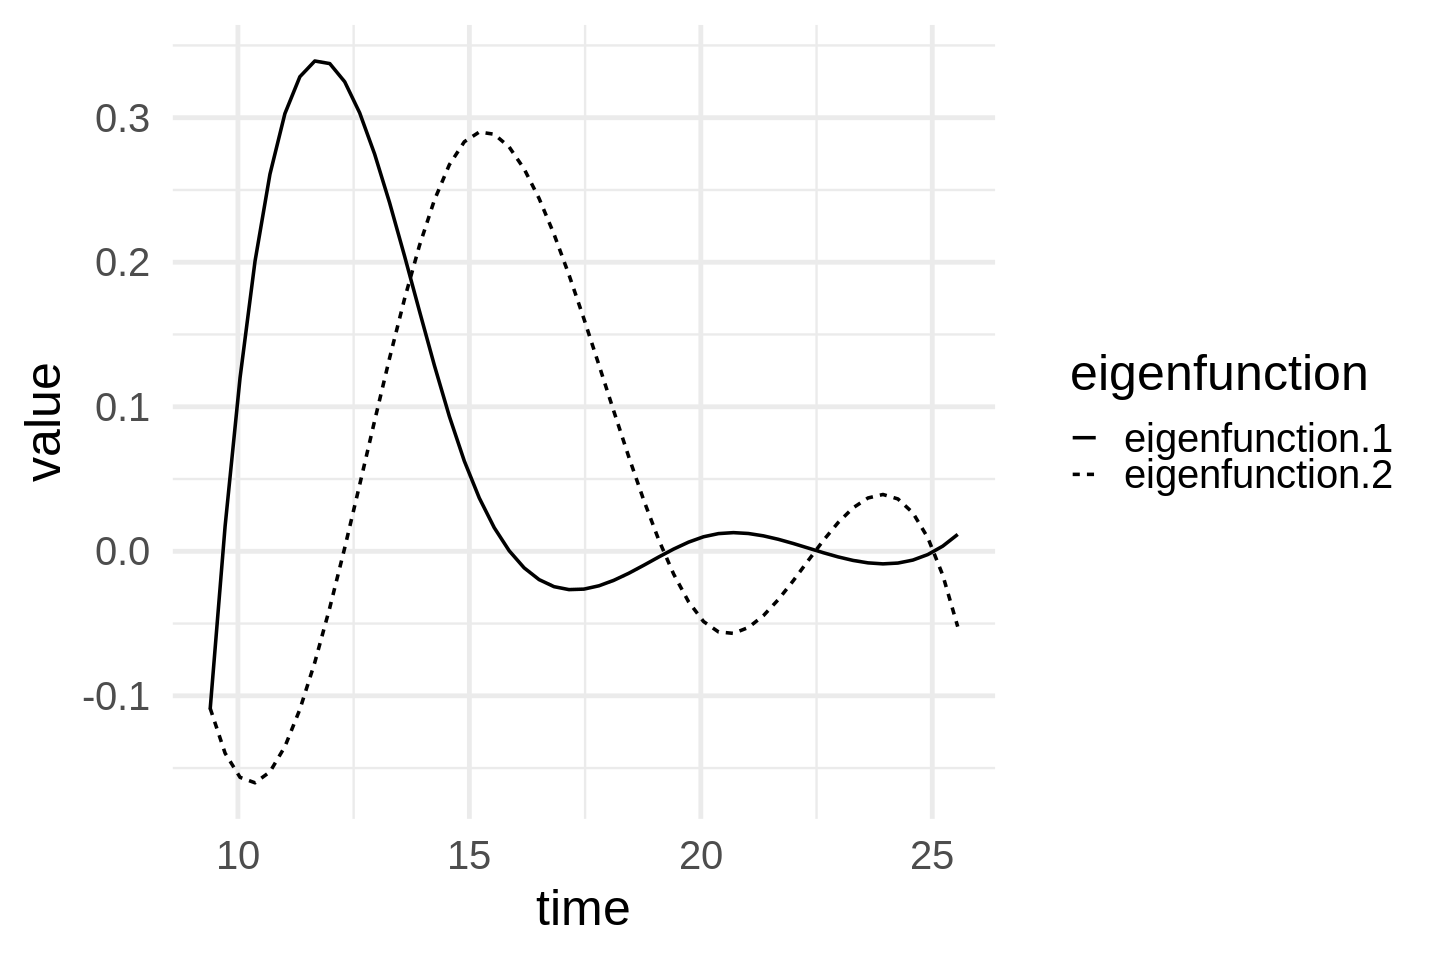

In [11]:
# convert data to ggplot format
data = data.frame(t(mdl.coefs$components )[,1:2], time=fit.fimpute$time.grid, method=rep("fimpute", 51)) %>%
   gather(eigenfunction, value, eigenfunction.1:eigenfunction.2)

# Plot two components from each method
options(repr.plot.width=12, repr.plot.height=8) # reverting back to default plotting settings
ggplot(data, aes(x=time, y=value, group=interaction(eigenfunction))) +
geom_line(aes(linetype=eigenfunction),size=1)

Note that these components are interpretable. Main variability within the population happens between the age of 12 and 18. The first component mainly captures the variance at the age of 12, while the second one around the age of 15.

## Qualitative comparison between fimpute and fpcs

For comparison, we run the James, Hastie, Sugar (2000) method within the same framework. Note that the `fpca` package, that we use to fit the data, automatically outputs plots of the mean curve.

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


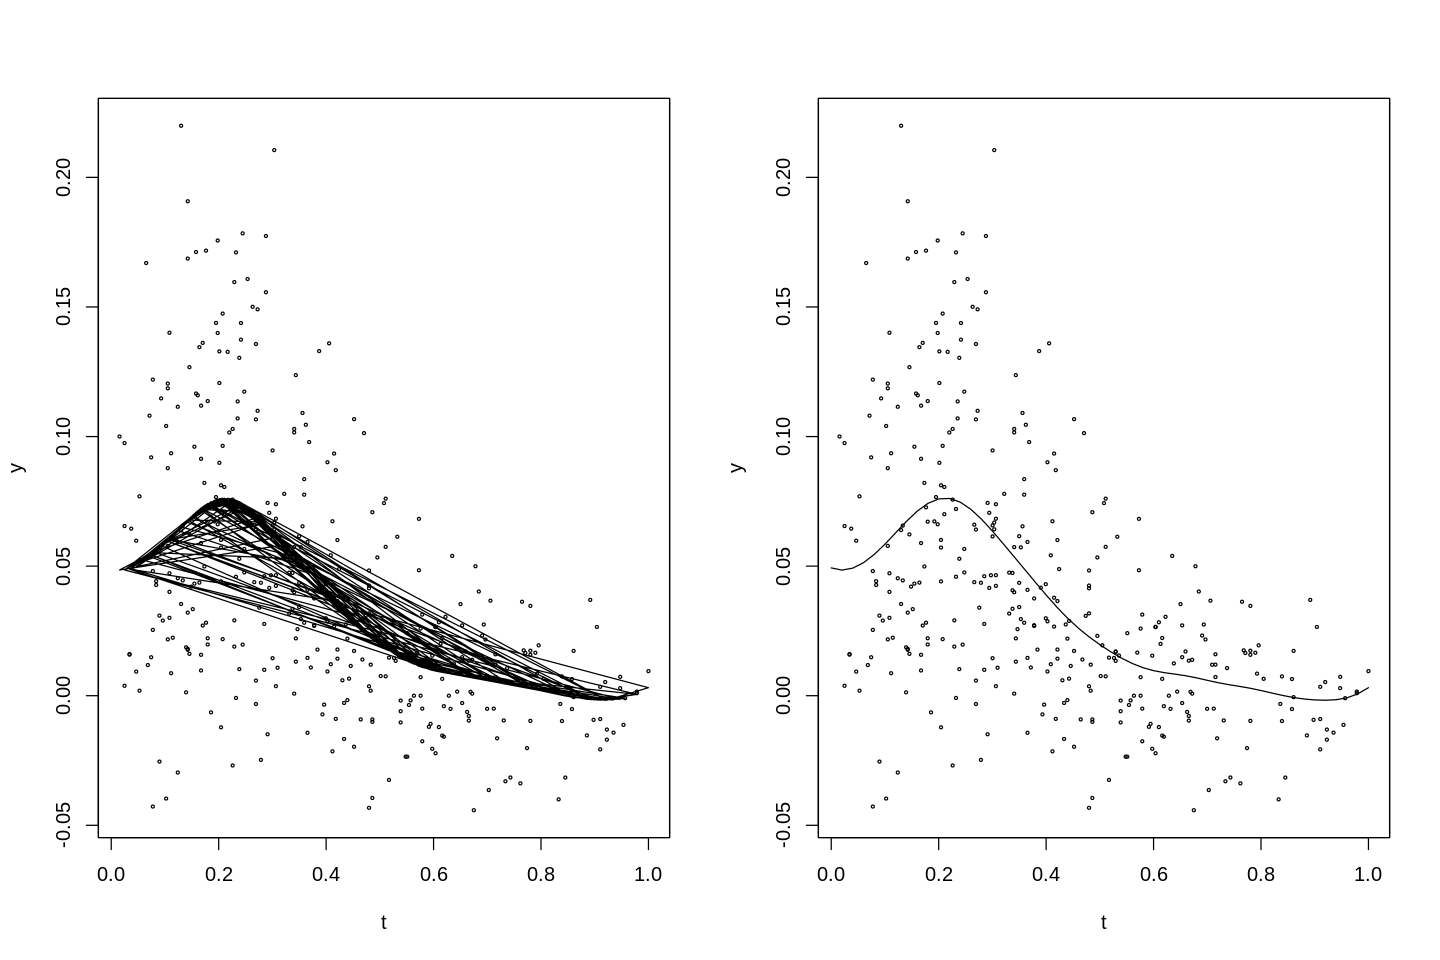

In [12]:
options(repr.plot.width=12, repr.plot.height=8) ; par(mfrow = c(1,2)) # for arrangement of plots
fit.fpc = fregression(spnbmd ~ age | idnum, data = bone, d = 6, K = 2, verbose = 0, method = "fpcs")

While `fpca` and `fimpute` methods generate components using different methodologies (EM algorithm and iterative application of SVD, respectively), they tend to find similar solutions. We can validate that qualitatively by plotting the estimated components  

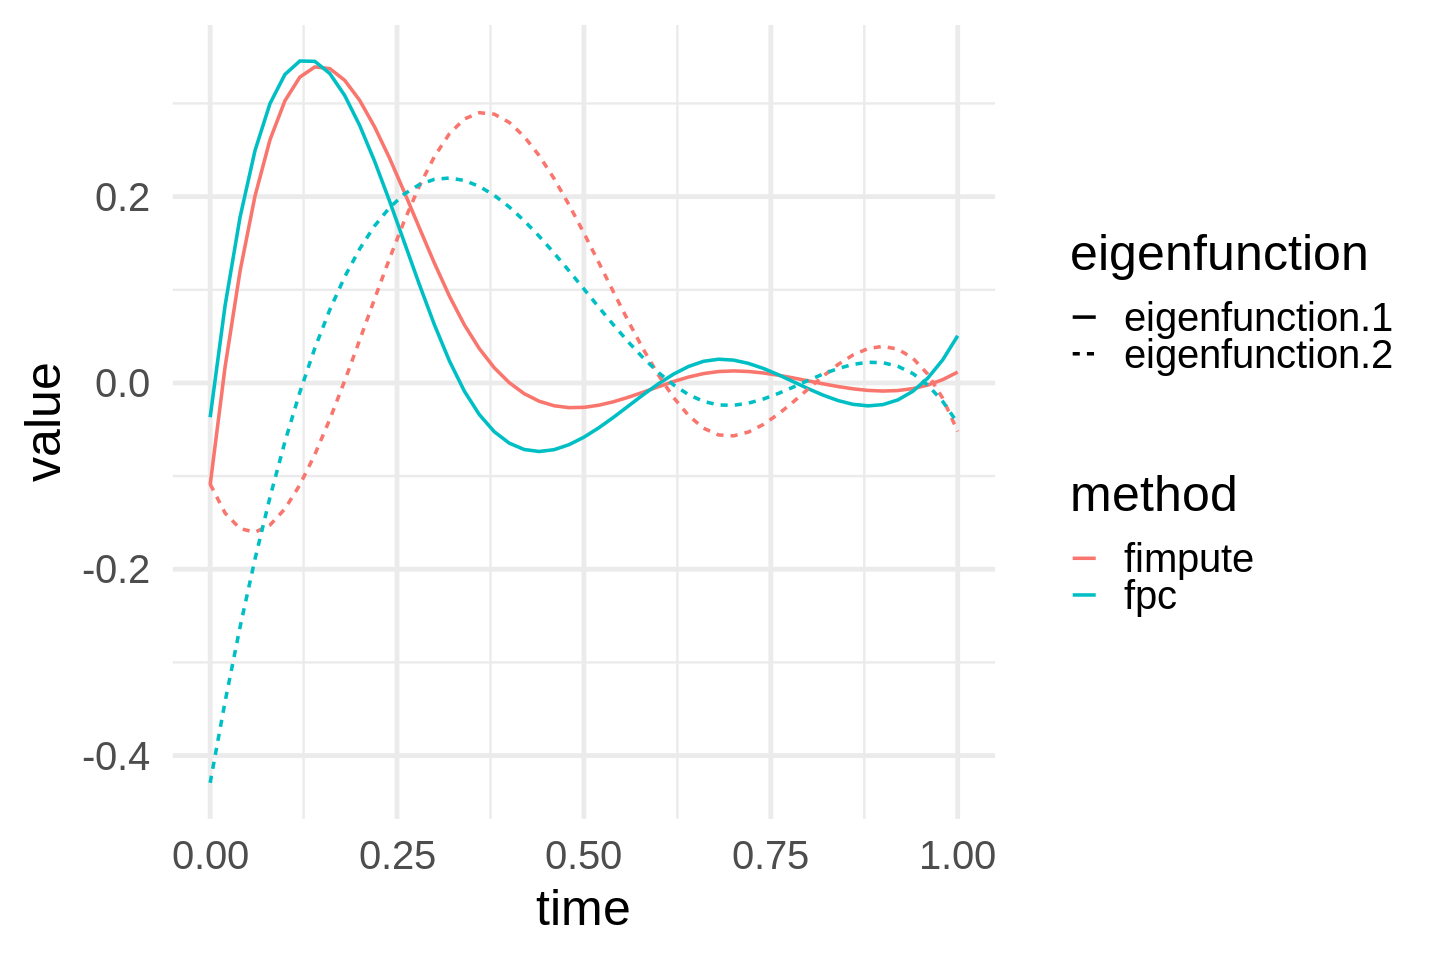

In [13]:
# convert data to ggplot format
data.fpc = data.frame(-t(coef(fit.fpc)$components ), time=0:50/50, method=rep("fpc", 51)) %>%
   gather(eigenfunction, value, eigenfunction.1:eigenfunction.2)
data.fimpute = data.frame(t(coef(fit.fimpute)$components )[,1:2], time=0:50/50, method=rep("fimpute", 51)) %>%
   gather(eigenfunction, value, eigenfunction.1:eigenfunction.2)
data = rbind(data.fpc, data.fimpute)

# Plot two components from each method
options(repr.plot.width=12, repr.plot.height=8) # reverting back to default plotting settings
ggplot(data, aes(x=time, y=value, group=interaction(method, eigenfunction), col=method)) +
geom_line(aes(linetype=eigenfunction),size=1)

Similarly, we expect the scores to be very highly correlated. Let's compute the correlation matrix

In [14]:
cor(coef(fit.fimpute)$scores,-coef(fit.fpc)$scores)

0.9474818,0.3182754
-0.2483157,0.8365122


As expected, scores from two methods are very highly correlated (large values on the diagonal). Note that we used `-coef(fit.fpc)$scores` -- since the components are unique up to a sign, sometimes the returned solutions from two methods can have similar structure but different signs.

## Analyzis of latent scores

We will analyze the latent representations of each subject. Let's see if there is a different progression pattern depending on gender

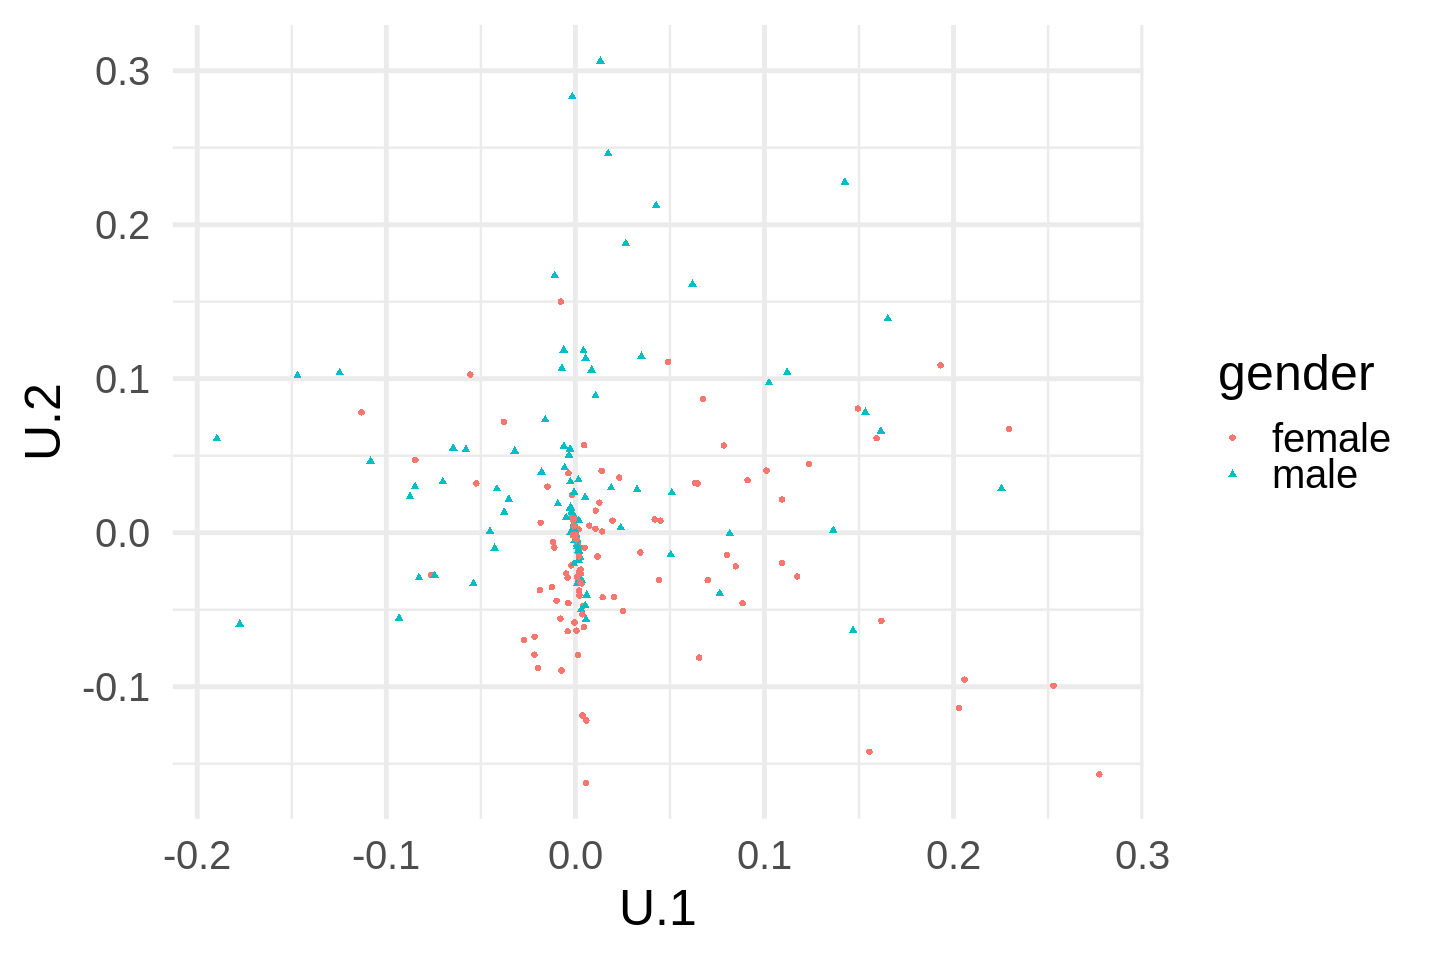

In [15]:
# Merged results from the fit with extra information from the dataset
data.gd = aggregate(list(gender = bone$gender), by=list(idnum = bone$idnum), FUN = function(x){x[1]}) 
data.pc = data.frame(idnum = rownames(fit.fimpute$fit), U = fit.fimpute$u)
data = merge(data.gd, data.pc, by="idnum")

options(repr.plot.width=12, repr.plot.height=8)
ggplot(data, aes(x=U.1, y=U.2, shape=gender, color=gender)) +
  geom_point()

We see some difference between the two populations. Our latent representation allows us also to reproduce the mean progression per gender. To visualize the progression curves, we first average values of scores per group. We use the `dplyr` package for that (you may need to install it if `library(dplyr)` throws an error. This package simplifies aggregation operation on data frames.

In [16]:
library("dplyr")
means = data %>% 
  group_by(gender) %>%
  summarize(U.1 = mean(U.1, na.rm = TRUE), U.2 = mean(U.2, na.rm = TRUE))
means


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




gender,U.1,U.2
<fct>,<dbl>,<dbl>
female,0.021451194,-0.009877568
male,0.001654497,0.031100041


Next we reconstruct the progression trends for these means

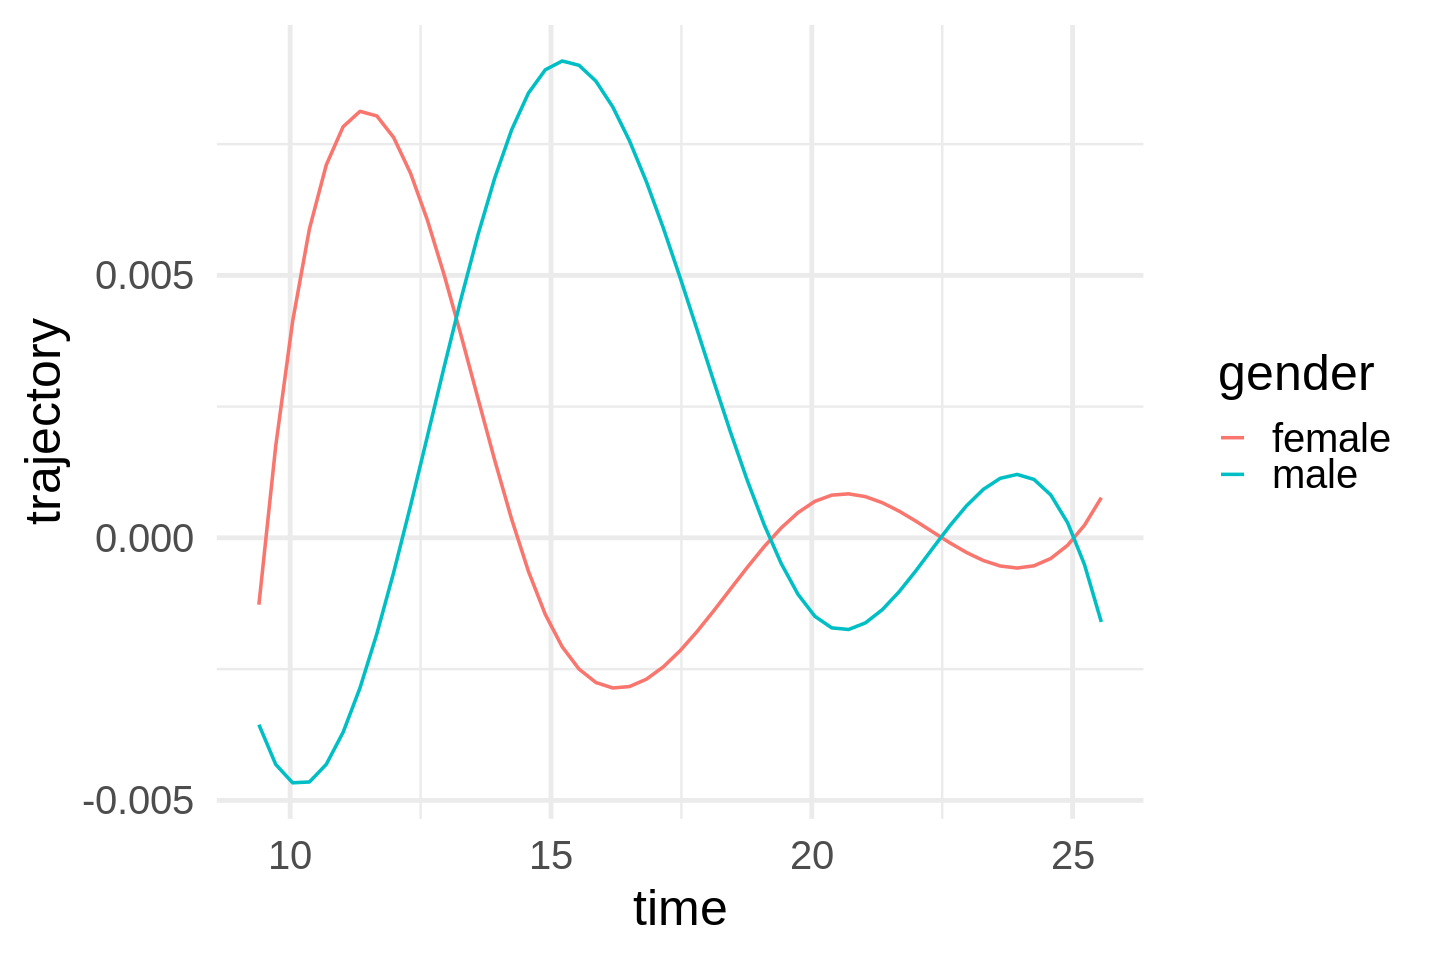

In [17]:
mdl.coefs = coef(fit.fimpute)
data = data.frame(time = fit.fimpute$time.grid, gender = t(as.matrix(means[,2:3]) %*% mdl.coefs$components))
colnames(data)[2:3] = c("female","male")
data = data %>% gather(gender, trajectory, female:male)
ggplot(data, aes(x=time,y=trajectory,color=gender)) + geom_line(size=1)

## Quanitative comparison of models

To quantitatively compare the models, we use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). We divide our dataset into two parts: a test set and the training set. For the test set we choose subjects with at least 2 measurements and set aside one of their measurements. We choose to have 10% observations in the test set.

**Warning**: This code can take several minutes to execute

In [18]:
dev.off()

experiment = function(i) {
    set.seed(i)
    split = sample.long(bone, "idnum", "age", "spnbmd", min.per.sbj = 2, ratio = 0.1)

    # Train both models on the training set
    fit.fimpute.train = fregression(spnbmd ~ age | idnum, data = split$train, d = 6, K = 2, lambda=0:5/50, fold=1, verbose = 0)
    fit.fpc.train = fregression(spnbmd ~ age | idnum, data = split$train, d = 6, K = 2, method="fpcs", verbose = 0)
    
    # Test both models on the test set
    preds.fimpute = predict(fit.fimpute.train, newdata = split$test)
    preds.fpc = predict(fit.fpc.train, newdata = split$test)

    # Compute 
    list(metrics = c(
        sum((preds.fimpute - split$test$spnbmd)**2),
        sum((preds.fpc - split$test$spnbmd)**2)
    ), model.fimpute = fit.fimpute.train, model.fpc = fit.fpc.train, split = split)
    
}
res = lapply(1:10, experiment )

null device 
          1

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


After having run the 10 experiments, we can compare the distribution of the test set error for both methods.

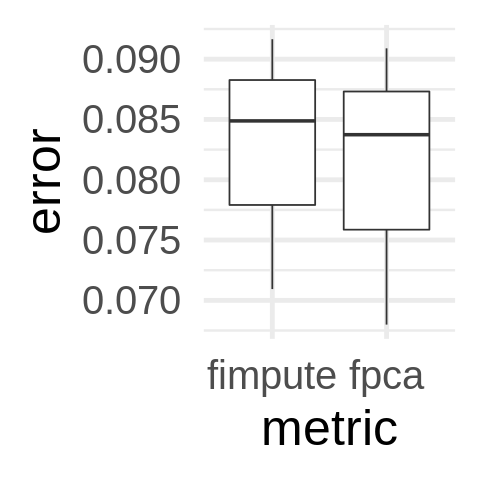

In [19]:
metrics = t(simplify2array(lapply(res, function(x){x$metrics})))
colnames(metrics) = c("fimpute","fpca")
options(repr.plot.width=4, repr.plot.height=4)
ggplot(data.frame(metrics) %>% gather(metric, error, fimpute:fpca), aes(x=metric, y=error)) +
  geom_boxplot()

Over 10 trials, we see that both methods have similar performance.

To illustrate the actual off-sample predictions, we plot curves from the last experiment. In the plot, full circles are the observations used for training, while empty circles are unknown observations from the test set. We present three estimated trajectories from three different subjects -- colors of the trajectories correspond to colors of the observations.

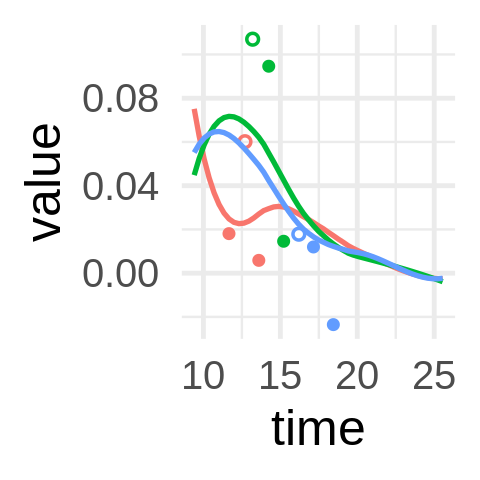

In [20]:
plot(res[[1]]$model.fimpute,rows=res[[1]]$split$test$idnum[1:3],test=res[[1]]$split$test[1:3,])

## Moving forward

In the other two vignettes we present more advanced features of the package. In [Regularization](regularization.html) vignette we show how to improve the model by choosing the right tuning parameter $\lambda$. In [Regression](regression.html) vignette we present how to incorporate other covariates in the model.